## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, cross_val_score


## Data

In [2]:
img = ImageDataGenerator()

In [3]:
data_path = '../Data/sample_Signature/sample_Signature/'

In [4]:
data = img.flow_from_directory(data_path, color_mode='grayscale', batch_size=300)

Found 300 images belonging to 2 classes.


In [5]:
data_images, data_labels = next(data)

In [6]:
data_images.shape

(300, 256, 256, 1)

In [7]:
data_images = data_images/255

In [8]:
data_labels = data_labels.T[[1]]
data_labels = data_labels.T.flatten()

In [9]:
X_train, X_test, y_train, y_test = \
        train_test_split(data_images, data_labels, random_state=42, test_size=.2)
X_traintrain, X_val, y_traintrain, y_val = \
        train_test_split(X_train, y_train, random_state=42, test_size=.2)

In [10]:
X_traintrain.shape

(192, 256, 256, 1)

In [11]:
y_traintrain.shape

(192,)

### Image Augmentation

#### Zoom Augmentation

In [12]:
aug = ImageDataGenerator(zoom_range=[.25,1])
aug.fit(X_traintrain)
aug_data = aug.flow(X_traintrain, y_traintrain, batch_size=192)


# for X_batch, y_batch in aug.flow(X_traintrain, y_traintrain, batch_size=192):
#     aug_images, aug_labels = X_batch, y_batch


In [13]:
aug_images, aug_labels = next(aug_data)

In [14]:
aug_images.shape

(192, 256, 256, 1)

In [15]:
aug_labels.shape

(192,)

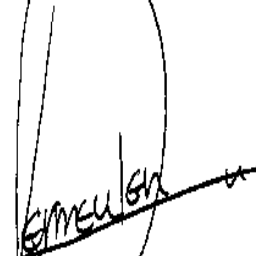

In [16]:
array_to_img(aug_images[0])

In [64]:
new_images1 = np.concatenate([X_traintrain, aug_images])

In [65]:
new_images1.shape

(384, 256, 256, 1)

In [67]:
new_labels1 = np.concatenate([y_traintrain, aug_labels])

In [68]:
new_labels1.shape

(384,)

#### Width Augmentation

In [57]:
aug = ImageDataGenerator(width_shift_range=.3)
aug.fit(X_traintrain)
aug2_data = aug.flow(X_traintrain, y_traintrain, batch_size=192)

In [58]:
aug2_data

In [59]:
aug2_images, aug2_labels = next(aug2_data)

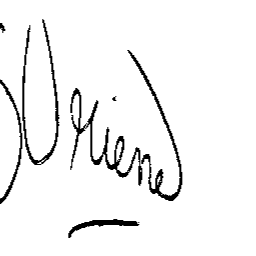

In [63]:
array_to_img(aug2_images[5])

In [66]:
new_images2 = np.concatenate([new_images1, aug2_images])

In [69]:
new_labels2 = np.concatenate([new_labels1, aug2_labels])

#### Height Augmentation

In [70]:
aug = ImageDataGenerator(height_shift_range=.3)
aug.fit(X_traintrain)
aug3_data = aug.flow(X_traintrain, y_traintrain, batch_size=192)

In [71]:
aug3_images, aug3_labels = next(aug3_data)

In [72]:
new_images3 = np.concatenate([new_images2, aug3_images])

In [73]:
new_labels3 = np.concatenate([new_labels2, aug3_labels])

#### Width Augmentation

In [77]:
aug = ImageDataGenerator(rotation_range=30)
aug.fit(X_traintrain)
aug4_data = aug.flow(X_traintrain, y_traintrain, batch_size=192)

In [78]:
aug4_images, aug4_labels = next(aug4_data)

In [79]:
new_images4 = np.concatenate([new_images3, aug4_images])

In [80]:
new_labels4 = np.concatenate([new_labels3, aug4_labels])

In [102]:
new_images4.shape

(960, 256, 256, 1)

In [103]:
new_labels4.shape

(960,)

#### A little bit of everything Augmentation

In [104]:
aug = ImageDataGenerator(zoom_range=[.7,.9], width_shift_range=.15, height_shift_range=.15, rotation_range=15)
aug.fit(new_images4)
aug_data_final = aug.flow(new_images4, new_labels4, batch_size=960)

In [105]:
aug_final_images, aug_final_labels = next(aug_data_final)

In [110]:
final_images = np.concatenate([new_images4, aug_final_images])

In [111]:
final_labels = np.concatenate([new_labels4, aug_final_labels])

In [112]:
final_images.shape

(1920, 256, 256, 1)

In [113]:
final_labels.shape

(1920,)

## Modeling

In [88]:
model = Sequential()


In [89]:
model.add(layers.Conv2D(filters=32,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(256,256,1)))

model.add(layers.MaxPool2D())

model.add(layers.Conv2D(64, (3,3), activation='relu'))


In [90]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [91]:
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(l=0.05)))
model.add(layers.Dropout(.25))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='tanh'))

In [92]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000000)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                32000032  
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

In [93]:
from tensorflow.keras.optimizers import SGD, Adam
sgd = SGD(learning_rate=.0001)
adam = Adam(learning_rate=.0001)

In [94]:
model.compile(optimizer=adam, \
              loss='binary_crossentropy', \
              metrics=['accuracy', 'AUC'],\
             experimental_run_tf_function=False) 

In [100]:
model.fit(X_traintrain, y_traintrain, epochs=5, \
          batch_size=10, validation_data=(X_val, y_val))

Train on 192 samples, validate on 48 samples
Epoch 1/5
192/192 [==============================] - 32s 167ms/sample - loss: 3.2653 - accuracy: 0.5260 - AUC: 0.2319 - val_loss: 1.6060 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 2/5
192/192 [==============================] - 28s 144ms/sample - loss: 2.4862 - accuracy: 0.5260 - AUC: 0.2972 - val_loss: 1.5022 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 3/5
192/192 [==============================] - 27s 142ms/sample - loss: 2.4804 - accuracy: 0.5260 - AUC: 0.3551 - val_loss: 1.4512 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 4/5
192/192 [==============================] - 27s 139ms/sample - loss: 2.0898 - accuracy: 0.5260 - AUC: 0.4601 - val_loss: 1.4117 - val_accuracy: 0.5000 - val_AUC: 0.5000
Epoch 5/5
192/192 [==============================] - 29s 149ms/sample - loss: 1.7989 - accuracy: 0.5260 - AUC: 0.3953 - val_loss: 1.3726 - val_accuracy: 0.5000 - val_AUC: 0.5000


In [114]:
model.fit(final_images, final_labels, epochs=5, \
          batch_size=10, validation_data=(X_val, y_val))

Train on 1920 samples, validate on 48 samples
Epoch 1/5
1920/1920 [==============================] - 273s 142ms/sample - loss: 6.4306 - accuracy: 0.5104 - AUC: 0.0331 - val_loss: 7.2178 - val_accuracy: 0.5417 - val_AUC: 0.0000e+00
Epoch 2/5
1920/1920 [==============================] - 276s 144ms/sample - loss: 6.1375 - accuracy: 0.5073 - AUC: 0.0328 - val_loss: 7.1721 - val_accuracy: 0.5417 - val_AUC: 0.0000e+00
Epoch 3/5
1810/1920 [===========================>..] - ETA: 15s - loss: 6.1311 - accuracy: 0.4956 - AUC: 0.0335

KeyboardInterrupt: 